# Installing the Tensorflow Docs
Document <a href="https://github.com/tensorflow/docs">Link</a>


In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done



# Importing the Vital LIbraries


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

# Global Variable Defining

* batch_size : 1024sample per iteration

* num_channels : only one channel because the Black and White image dataset

* num_classes : it contains [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] classes

* image_size : However the HodaDataset contains 32\*32 images but I prefer to

* load these images in 28\*28 scale

* Latent_dim : Its a noise vector (because in normal way maybe the generator will be stucked in only one class and generate only one type of images)

In [3]:
batch_size = 1024
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 32

# Downloading the Dataset (Hoda Dataset)

<h4 style="color: red">Hint : By running this section the HodaDataset will be clone in your colab file manager. and you can access to all of the datasets in "HodaDatasetReader" Directory.</h4>

In [4]:
!git clone https://github.com/amir-saniyan/HodaDatasetReader.git

Cloning into 'HodaDatasetReader'...

remote: Enumerating objects: 24, done.

remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24

Receiving objects: 100% (24/24), 6.34 MiB | 9.68 MiB/s, done.

Resolving deltas: 100% (6/6), done.


# Loading the Data

Loading data with 28 pixel for each height and width and without any <a href="https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/"> one_hot_encodding </a>

In [5]:
from HodaDatasetReader.HodaDatasetReader import read_hoda_dataset
train_images, train_labels = read_hoda_dataset(
    dataset_path='HodaDatasetReader/DigitDB/Train 60000.cdb',
    images_height=28,
    images_width=28,
    one_hot=False,
    reshape=True)

test_images, test_labels = read_hoda_dataset(
    dataset_path='HodaDatasetReader/DigitDB/Test 20000.cdb',
    images_height=28,
    images_width=28,
    one_hot=False,
    reshape=True)

# Preprocecing on Data

* This dataset doesn't need any Normalization because it has a binary pixle rate image (It means the pixels that contain in this dataset images exclusively are zero or one) and they don't need any normalization.

* With Normalization the generator only generate pure black images.

* all_digits array contains 80,000 images (60,000 Train, 20,000 Test)

* all_labels array contains 80,000 one_hot_encode labels:
* * 5 : [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [6]:
all_digits = np.concatenate([train_images, test_images])
all_labels = np.concatenate([train_labels, test_labels])

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
all_digits = all_digits.astype("float32")
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
all_labels = keras.utils.to_categorical(all_labels, 10)

# Create tf.data.Dataset.
dataset = tf.data.Dataset.from_tensor_slices((all_digits, all_labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

print(f"Shape of training images: {all_digits.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (80000, 28, 28, 1)

Shape of training labels: (80000, 10)


# Channel size Implimenting

* because of the conditional Generator we need added the class labels to noise vector because in each iteration we can call the generator to create only which classes for example we call the model restrictively generate 5 so we must pass the 5 with noise vector.

In [7]:
generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes
print(generator_in_channels, discriminator_in_channels)

42 11


# Build models

Discriminatro : The discriminator is a classifier that determines if the input samples are real or fake. These input samples can be real samples coming from the training data, or fake coming from the generator.

Generator : A Generator in GANs is a neural network that creates fake data to be trained on the discriminator. It learns to generate plausible data. The generated examples/instances become negative training examples for the discriminator. It takes a fixed-length random vector carrying noise as input and generates a sample.

* The Discriminator model is similar to the common classifier model but in GAN We prefer to Use <a href="https://sthalles.github.io/intro-to-gans/#:~:text=Many%20activation%20functions%20will%20work,truncating%20negative%20values%20to%200.">"LeakyReLU" </a>

* In Generator we prefer to start with small images like this lab that we start with 7 * 7 images and then in each main layers ( Conv2D layers ) we will enhance their size 2 times for example in the second Conv2DTranspose our output will imporve to 14 * 14 images.

In [8]:
discriminator = keras.Sequential(
    [
        keras.layers.InputLayer((28, 28, discriminator_in_channels)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

generator = keras.Sequential(
    [
        keras.layers.InputLayer((generator_in_channels,)),
        # We want to generate 128 + num_classes coefficients to reshape into a
        # 7x7x(128 + num_classes) map.
        layers.Dense(7 * 7 * generator_in_channels),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((7, 7, generator_in_channels)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.BatchNormalization(),
        layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

# Load pre-trained Model

* The pre-trained models are available in project git lab and they are simply can generate your favorite numbers without any model training process and time wasting.

In [10]:
generator.load_weights('g3.h5')
discriminator.load_weights('d3.h5')

## Class Definition:
<ul>
<li>The code defines a class called ConditionalGAN that extends the keras.Model class. This class represents the entire cGAN model.
<li>The constructor (__init__) initializes the discriminator, generator, and other necessary variables.
<li>It also creates two metrics trackers (gen_loss_tracker and disc_loss_tracker) to monitor the generator and discriminator losses during training.
</ul>

## Metrics:

<li> The @property decorator defines a method called metrics that returns a list of metrics to be tracked during training. In this case, it returns [gen_loss_tracker, disc_loss_tracker].
## Compilation:

<li>The compile method is overridden to configure the model for training.
<li>It takes three arguments: d_optimizer (discriminator optimizer), g_optimizer (generator optimizer), and loss_fn (the loss function).
These arguments are stored as attributes of the model for later use.

## Training Step:

<li>The train_step method is overridden to define a custom training step for the cGAN.
<li>It takes a batch of data (data) as input, which includes real images and their corresponding one-hot labels.
<li>The method starts by unpacking the real images and labels.

## Preprocessing:

<li>The labels are processed to be compatible with the discriminator. They are expanded to match the size of the images and reshaped accordingly.
<li>Random latent vectors are sampled from the latent space, and the one-hot labels are concatenated with these vectors to create random vector labels for the generator.

## Discriminator Training:

<li>The generator is used to generate fake images based on the random vector labels.
<li>The generated images and the real images are concatenated with their corresponding labels.
<li>The discriminator is trained to classify these combined images as real or fake, and the loss is calculated based on the predictions.
<li>The gradients of the discriminator's trainable weights with respect to the loss are computed using tf.GradientTape.
<li>The discriminator optimizer is then applied to update the discriminator's weights.

## Generator Training:

<li>Another set of random latent vectors is sampled.
<li>The generator is used to generate fake images based on the random vector labels (including the same labels as before).
<li>These generated fake images are concatenated with their corresponding labels.
<li>The discriminator is then used to classify these fake images, and the loss is calculated.
<li>The gradients of the generator's trainable weights with respect to the loss are computed using tf.GradientTape.
<li>The generator optimizer is applied to update the generator's weights.

## Loss Tracking and Return:

<li>The losses for the generator and discriminator are updated in their respective loss trackers (gen_loss_tracker and disc_loss_tracker).
<li>The method returns a dictionary containing the current values of the generator and discriminator losses.

In [11]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
        real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
        combined_images = tf.concat(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


# Instance Creation

In [12]:
cond_gan = ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)

# Compile and Fit Section

* In each time the model can train with different hyper parameters (Learning rate & Epochs)

## Hint : Don't pay attention to Loss function Like simple deep learning model.

In [ ]:
# # for i in range(5):
#   dlistofrate = [5e-4, 4e-4, 3e-4, 2e-4, 1e-4]
#   glistofrate = [9e-4, 7e-4, 5e-4, 3e-4, 1e-4]
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)
history = cond_gan.fit(dataset, epochs=50)
  # print("-------------------------------------------------------")
  # plt.plot(history.history['d_loss'])
  # plt.plot(history.history['g_loss'])
  # print("-------------------------------------------------------")

Epoch 1/50

79/79 [==============================] - 33s 368ms/step - g_loss: 0.8573 - d_loss: 0.6440

Epoch 2/50

79/79 [==============================] - 29s 361ms/step - g_loss: 0.8803 - d_loss: 0.6219

Epoch 3/50

79/79 [==============================] - 28s 359ms/step - g_loss: 0.8734 - d_loss: 0.6323

Epoch 4/50

79/79 [==============================] - 29s 362ms/step - g_loss: 0.8721 - d_loss: 0.6253

Epoch 5/50

79/79 [==============================] - 29s 361ms/step - g_loss: 0.8711 - d_loss: 0.6291

Epoch 6/50

79/79 [==============================] - 28s 360ms/step - g_loss: 0.8698 - d_loss: 0.6292

Epoch 7/50

79/79 [==============================] - 29s 361ms/step - g_loss: 0.8734 - d_loss: 0.6265

Epoch 8/50

79/79 [==============================] - 29s 363ms/step - g_loss: 0.8671 - d_loss: 0.6342

Epoch 9/50

79/79 [==============================] - 29s 361ms/step - g_loss: 0.8789 - d_loss: 0.6246

Epoch 10/50

79/79 [==============================] - 29s 361ms/step - g_

# Visualization

In [13]:
plt.plot(history.history['d_loss'])
plt.plot(history.history['g_loss'])

NameError: ignored

# Interpolating between classes with the trained generator



In [14]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 10  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 4  # @param {type:"slider", min:0, max:9, step:1}
end_class = 4  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)

1/1 [==============================] - 8s 8s/step


# Showing the Generated numbers

In [15]:
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=2)
embed.embed_file("animation.gif")

TypeError: ignored

# Saving the model

In [ ]:
discriminator.save_weights('d3.h5')
generator.save_weights('g3.h5')

1/1 [==============================] - 0s 87ms/step


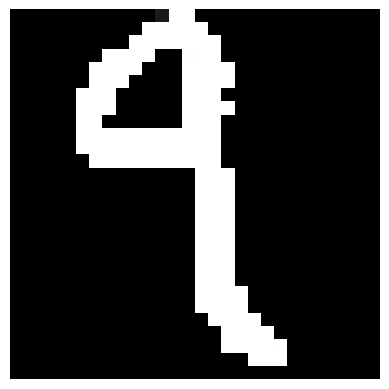

In [16]:
latent_vector = np.random.normal(0, 1, (1, latent_dim))
label = np.array([9])  # Choose a label for the generated image
one_hot_label = tf.keras.utils.to_categorical(label, num_classes)
input_data = np.concatenate((latent_vector, one_hot_label), axis=1)
generated_image = generator.predict(input_data)

# Rescale the pixel values to the range [0, 255]
generated_image = (generated_image * 255).astype(np.uint8)

# Display the generated image
import matplotlib.pyplot as plt

plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.axis("off")
plt.show()

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 16ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 17ms/step

1/1 [==============================] - 0s 15ms/step


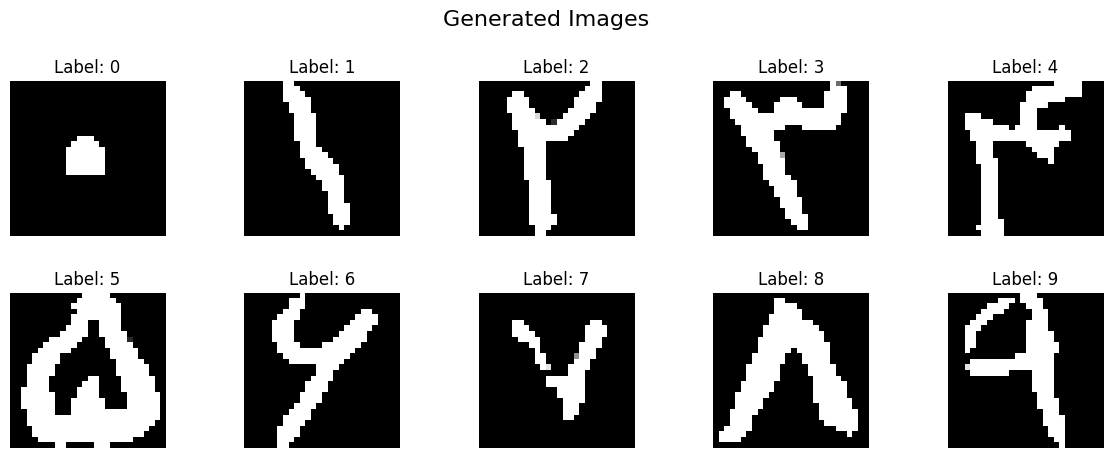

In [17]:
num_rows = 2
num_cols = 5
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 5))
fig.suptitle("Generated Images", fontsize=16)
fig.tight_layout(pad=2.0)

for i in range(10):
    # Generate a single image for the current label
    latent_vector = np.random.normal(0, 1, (1, latent_dim))
    label = np.array([i])  # Choose a label for the generated image
    one_hot_label = tf.keras.utils.to_categorical(label, num_classes)
    input_data = np.concatenate((latent_vector, one_hot_label), axis=1)
    generated_image = generator.predict(input_data)

    # Rescale the pixel values to the range [0, 255]
    generated_image = (generated_image * 255).astype(np.uint8)

    # Display the generated image
    ax = axs[i // num_cols, i % num_cols]
    ax.imshow(generated_image[0, :, :, 0], cmap="gray")
    ax.set_title(f"Label: {i}")
    ax.axis("off")

plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Load the Hoda dataset
print('Reading train dataset (Train 60000.cdb)...')
X_train, Y_train = read_hoda_dataset(dataset_path='HodaDatasetReader/DigitDB/Train 60000.cdb',
                                     images_height=28,
                                     images_width=28,
                                     one_hot=False,
                                     reshape=True)

X_train = X_train.reshape(-1, 28, 28, 1)

# Preprocess the data
X_train = X_train.astype('float32') / 255.0
Y_train = to_categorical(Y_train)

# Split the dataset into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Define the classifier model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the classifier
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_val, Y_val))


# Evaluate the classifier on the test set
print('Reading test dataset (Test 20000.cdb)...')
X_test, Y_test = read_hoda_dataset(dataset_path='HodaDatasetReader/DigitDB/Test 20000.cdb',
                                   images_height=28,
                                   images_width=28,
                                   one_hot=False,
                                   reshape=True)

# Preprocess the test data
X_test = X_test.astype('float32') / 255.0
Y_test = to_categorical(Y_test)

# Reshape the test data for compatibility with the classifier model
X_test = np.reshape(X_test, (-1, 28, 28, 1))

# Evaluate the classifier
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

Reading train dataset (Train 60000.cdb)...

Epoch 1/10

375/375 [==============================] - 6s 8ms/step - loss: 0.8033 - accuracy: 0.7620 - val_loss: 0.2710 - val_accuracy: 0.9172

Epoch 2/10

375/375 [==============================] - 2s 5ms/step - loss: 0.2079 - accuracy: 0.9362 - val_loss: 0.1789 - val_accuracy: 0.9453

Epoch 3/10

375/375 [==============================] - 2s 5ms/step - loss: 0.1490 - accuracy: 0.9548 - val_loss: 0.1409 - val_accuracy: 0.9592

Epoch 4/10

375/375 [==============================] - 2s 5ms/step - loss: 0.1169 - accuracy: 0.9645 - val_loss: 0.1160 - val_accuracy: 0.9670

Epoch 5/10

375/375 [==============================] - 2s 5ms/step - loss: 0.0972 - accuracy: 0.9709 - val_loss: 0.1034 - val_accuracy: 0.9707

Epoch 6/10

375/375 [==============================] - 3s 7ms/step - loss: 0.0835 - accuracy: 0.9755 - val_loss: 0.0916 - val_accuracy: 0.9737

Epoch 7/10

375/375 [==============================] - 2s 6ms/step - loss: 0.0728 - accuracy

In [ ]:
Label_List = np.random.randint(0, 10, 1000)
generated_labels = []

for i in range(1000):
    latent_vector = np.random.normal(0, 1, (1, latent_dim))
    label = np.array([Label_List[i]])  # Choose a label for the generated image
    one_hot_label = tf.keras.utils.to_categorical(label, num_classes)
    input_data = np.concatenate((latent_vector, one_hot_label), axis=1)
    generated_image = generator.predict(input_data)

    generated_predictions = model.predict(generated_image)
    generated_label = np.argmax(generated_predictions, axis=1)
    generated_labels.append(generated_label[0])  # Append the generated label to the list

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 127ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 18ms/step

1/1 [==============================] - 0s 19ms/step

1/1 [==============================] - 0s 20ms/step

1/1 [==============================] - 0s 21m

In [ ]:
print('Classification Report for Generated Digits:')
Report = classification_report(Label_List, generated_labels)
print(Report)

Classification Report for Generated Digits:

              precision    recall  f1-score   support



           0       0.99      1.00      0.99        95

           1       0.99      1.00      1.00       103

           2       0.91      1.00      0.95        97

           3       0.94      0.93      0.94       101

           4       1.00      0.90      0.95        94

           5       1.00      0.95      0.97       102

           6       1.00      0.98      0.99        96

           7       1.00      1.00      1.00       107

           8       0.95      0.97      0.96        94

           9       0.96      0.98      0.97       111



    accuracy                           0.97      1000

   macro avg       0.97      0.97      0.97      1000

weighted avg       0.97      0.97      0.97      1000


